In [4]:
from platform import python_version
print(python_version())

3.9.7


In [2]:
import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [4]:
# X AND Y (no splitting for train/test)
# Financial ratios 
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
# annual stock performances
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", index_col=0)
# convert to date
y["Date"], y["Date2"]=pd.to_datetime(y["Date"]), pd.to_datetime(y["Date2"])

# X AND Y (splitting for train/test)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

y_=pd.DataFrame()
y_=y.loc[y_test.index.values, :]

# convert string to datetime
y_["Date"], y_["Date2"]=pd.to_datetime(y_["Date"]), pd.to_datetime(y_["Date2"])

In [5]:
y_.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
9836,LNT,38.33,2018-02-23,7.473035e+07,LNT,45.75,2019-02-25,6.141256e+07
5390,EBF,15.88,2015-05-08,3.283809e+06,EBF,18.99,2016-05-09,2.965383e+06
13349,PSX,77.52,2015-02-20,3.539637e+08,PSX,81.05,2016-02-22,2.656705e+08
7921,HROW,2.44,2017-03-21,1.542714e+05,HROW,1.78,2018-03-21,7.962652e+04
7193,GME,22.52,2011-03-30,7.990321e+07,GME,23.21,2012-03-29,2.067408e+08


In [6]:
y.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,248323864.0,A,29.60,2009-12-21,93198560.0
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,146961945.0
2,A,40.10,2010-12-20,161350370.0,A,33.99,2011-12-20,124797684.0
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,138114908.0
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,169766380.0


In [7]:
y_train

,Perf
317,-0.707602
4869,0.247619
63,1.311688
3668,1.689754
14236,-0.038902
...,...
740,0.045642
1032,0.250000
5520,0.330387
3046,-0.149632


In [8]:
# Calculate Altman Z'' scores 1995
def calcZScores(x):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['Book Equity/TL']
    return Z

In [9]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData():
    daily_stock_prices=pd.read_csv('C:/Users/Usuario/MachineLearning/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv',\
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', daily_stock_prices.shape)
    return daily_stock_prices

In [10]:
# backtest data
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (8125701, 11)


In [11]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [12]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [13]:
def getStockPriceData(ticker, y_, mask, daily_stock_prices, rows):
    date1 = y_[mask][y_[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_[mask][y_[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [14]:
def getDataForDateRange(date_Index_New, rows):
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")]) #might be a way to speed this up.
    return WeeklyStockDataRows

In [15]:
def getStockTimeSeries(dateTimeIndex, y_, tickers, mask, daily_stock_prices):
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows=pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_, mask, daily_stock_prices, rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new, rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick]=WeeklyStockDataRows["Close"].values
    return stockRet

In [16]:
def getPortfolioRelativeTimeSeries(stockRet):
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [17]:
def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(x)
    # 3.75 is approx. B- rating
    zbl = (z['Z score'][mask].reset_index(drop=True) > 3) 
    y_pred_z = y_pred[zbl]
    # Get bool list of top stocks
    bl = (y_pred_z[0] > y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl & zbl]) 
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[mask].reset_index(drop=True)[bl & zbl]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_,\
                                  ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [18]:
def getPortTimeSeries(y_, x, daily_stock_prices, ml_model_pipeline, verbose=True):
    dr=pd.date_range(start='2009-01-01', periods=11, freq='Y') # Date range
    port_perf_all_years = pd.DataFrame()
    ref=1 # relative performance reference.
    for curr_date in dr:
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_, x,\
                                 daily_stock_prices, ml_model_pipeline)
        if verbose:
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        this_year_perf = this_year_perf * ref
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        ref = this_year_perf.iloc[-1]
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

In [18]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
pl_linear = pickle.load(open("pl_linear.p", "rb" ))
test = getPortTimeSeries(y_, X_test, daily_stock_prices, pl_linear, verbose=True)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 10.96 %
With stocks: ['AMKR' 'BMS' 'TEL' 'IPG' 'MGLN' 'PRDO' 'AMD']
AMKR Performance was: 24.59 %
BMS Performance was: 12.42 %
TEL Performance was: 23.77 %
IPG Performance was: 29.42 %
MGLN Performance was: 11.74 %
PRDO Performance was: -27.1 %
AMD Performance was: 1.9 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -20.72 %
With stocks: ['TWI' 'AMD' 'SNEX' 'PLAB' 'TST' 'LYV' 'NCMI']
TWI Performance was: -9.19 %
AMD Performance was: -39.21 %
SNEX Performance was: 2.84 %
PLAB Performance was: -2.32 %
TST Performance was: -44.7 %
LYV Performance was: -19.16 %
NCMI Performance was: -33.3 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: 8.51 %
With stocks: ['STRR' 'GRA' 'MPC' 'SAVE' 'NUVA' 'LEA' 'CCXI']
STRR Performance was: -3.94 %
GRA Performance was: 20.6 %
MPC Performance was: 45.97 %
SAVE Perfo

# LOOP


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

In [20]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
        ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
        ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))
    ])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))
    ])
    pl_rfregressor.fit(X_train, y_train)
    
    return pl_rfregressor


# BUSCAR BUEN SPLIT 

In [21]:
# Y percentage perf
y_pec=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)["Perf"]

In [22]:
y_=y.loc[y_test.index.values, :]

In [23]:
y_


,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
9836,LNT,38.33,2018-02-23,7.473035e+07,LNT,45.75,2019-02-25,6.141256e+07
5390,EBF,15.88,2015-05-08,3.283809e+06,EBF,18.99,2016-05-09,2.965383e+06
13349,PSX,77.52,2015-02-20,3.539637e+08,PSX,81.05,2016-02-22,2.656705e+08
7921,HROW,2.44,2017-03-21,1.542714e+05,HROW,1.78,2018-03-21,7.962652e+04
7193,GME,22.52,2011-03-30,7.990321e+07,GME,23.21,2012-03-29,2.067408e+08
...,...,...,...,...,...,...,...,...
7061,GFF,12.14,2018-11-19,5.032637e+06,GFF,22.56,2019-11-19,4.448877e+06
9485,LAMR,57.64,2015-02-26,8.040475e+07,LAMR,56.05,2016-02-26,2.908272e+07
7699,HLF,30.40,2017-02-23,1.664804e+08,HLF,41.92,2018-02-23,1.681729e+08
7312,GRA,72.01,2017-02-23,5.103601e+07,GRA,66.93,2018-02-23,2.901596e+07


In [25]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_rfregressor']

for model in model_pipeline_list:
    for myTstSze in [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]:
        X_train, X_test, y_train, y_test = train_test_split(x, y_pec,\
                                                            test_size=myTstSze)
        
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)

        else:
            # Linear mdoel default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_=y.loc[y_test.index.values, :]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_, X_test,\
                                 daily_stock_prices, model_pl, verbose=False) 
        
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performance:', round(perf, 2), 'Volatility:', round(vol,2),\
              'Model', model, 'Test size: ', myTstSze)

Performance: 2.19 Volatility: 0.42 Model pl_linear Test size:  0.02
Performance: 0.96 Volatility: 0.31 Model pl_linear Test size:  0.1
Performance: 2.09 Volatility: 0.47 Model pl_linear Test size:  0.25
Performance: 9.43 Volatility: 1.55 Model pl_linear Test size:  0.5
Performance: 4.95 Volatility: 0.67 Model pl_linear Test size:  0.75
Performance: 9.92 Volatility: 1.21 Model pl_linear Test size:  0.9
Performance: 3.1 Volatility: 0.36 Model pl_linear Test size:  0.98
Performance: 2.51 Volatility: 0.56 Model pl_KNeighbors Test size:  0.02
Performance: 4.47 Volatility: 0.66 Model pl_KNeighbors Test size:  0.1
Performance: 3.65 Volatility: 0.95 Model pl_KNeighbors Test size:  0.25
Performance: 5.43 Volatility: 1.02 Model pl_KNeighbors Test size:  0.5
Performance: 4.31 Volatility: 0.75 Model pl_KNeighbors Test size:  0.75
Performance: 5.33 Volatility: 0.7 Model pl_KNeighbors Test size:  0.9
Performance: 5.14 Volatility: 0.73 Model pl_KNeighbors Test size:  0.98
Performance: 7.39 Volatility

In [ ]:
# Choose the model pipelines to run loop for
#model_pipeline_list = ['pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_linear', 'pl_GradBregressor', 'pl_KNeighbors', 'pl_ElasticNet']
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree', 'pl_rfregressor']

i, results = 0, []
for model in model_pipeline_list:
    tests_per_model=1200
    for test_num in range(0, tests_per_model):
        X_train, X_test, y_train, y_test = train_test_split(x, y_pec,\
                                                            test_size=0.5)
        #Train different models
        if (model =='pl_linear'):
            model_pl = trainLinearModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)

        y_=y.loc[y_test.index.values, :]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_, X_test,\
                             daily_stock_prices, model_pl, verbose=False) 
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performed test ',i , [i, model, perf, vol])
        results.append([i, model, perf, vol])
        i=i+1

# Save our results for plotting
results_df = pd.DataFrame(results, columns=["Test Number",\
                                            "Model Used",\
                                            "Indexed Return",\
                                            "Annual Volatility"])
results_df.to_csv("Backtest_statistics_Big.csv")

Performed test  0 [0, 'pl_linear', 3.0588795713317243, 0.5427567421898815]
Performed test  1 [1, 'pl_linear', 5.339157602888931, 0.9669449620683466]
Performed test  2 [2, 'pl_linear', 2.2208564538014812, 0.5175132465275152]
Performed test  3 [3, 'pl_linear', 3.8312350896654364, 0.5723816388065213]
Performed test  4 [4, 'pl_linear', 7.354027030956854, 1.0629611718068082]
Performed test  5 [5, 'pl_linear', 4.277601163309991, 0.6960528305559358]
Performed test  6 [6, 'pl_linear', 9.06161937832373, 1.455281770006751]
Performed test  7 [7, 'pl_linear', 9.683827306052361, 1.5939368825841056]
Performed test  8 [8, 'pl_linear', 4.476295382187539, 0.8614865405491126]
Performed test  9 [9, 'pl_linear', 2.8057828465640697, 0.6436836040499936]
Performed test  10 [10, 'pl_linear', 3.3258628661556573, 0.6780937448359611]
Performed test  11 [11, 'pl_linear', 13.708061500841481, 1.9276725148268241]
Performed test  12 [12, 'pl_linear', 7.429155508900909, 0.9431314604217887]
Performed test  13 [13, 'pl_

Performed test  108 [108, 'pl_linear', 5.343335806614774, 0.8002314019966246]
Performed test  109 [109, 'pl_linear', 5.35706358482447, 0.8965841324661049]
Performed test  110 [110, 'pl_linear', 2.0582702299675355, 0.44254618238825233]
Performed test  111 [111, 'pl_linear', 3.540954464372814, 0.5136650353150334]
Performed test  112 [112, 'pl_linear', 1.768836026141086, 0.38072571434910535]
Performed test  113 [113, 'pl_linear', 3.698125339871509, 0.6032590899281594]
Performed test  114 [114, 'pl_linear', 4.153313346039107, 0.5323051004895988]
Performed test  115 [115, 'pl_linear', 4.538548612612059, 0.7477628051224505]
Performed test  116 [116, 'pl_linear', 3.8037843358706023, 0.6312154167631548]
Performed test  117 [117, 'pl_linear', 3.272324909520674, 0.4706682692369035]
Performed test  118 [118, 'pl_linear', 3.735223506930045, 0.7518828080157254]
Performed test  119 [119, 'pl_linear', 9.43285876254033, 1.3377690614657562]
Performed test  120 [120, 'pl_linear', 3.7878981636813798, 0.6

Performed test  213 [213, 'pl_linear', 3.5927644840255066, 0.889817989133775]
Performed test  214 [214, 'pl_linear', 4.109802502469442, 0.8605837329207945]
Performed test  215 [215, 'pl_linear', 2.2101397094535518, 0.5191741135942453]
Performed test  216 [216, 'pl_linear', 6.38426772847236, 1.1904633965622393]
Performed test  217 [217, 'pl_linear', 10.633477888830658, 1.6985116564950242]
Performed test  218 [218, 'pl_linear', 8.59496249234549, 1.1639331509684159]
Performed test  219 [219, 'pl_linear', 6.363010888983545, 0.9082516072718266]
Performed test  220 [220, 'pl_linear', 3.3796565398212053, 0.6821881727748165]
Performed test  221 [221, 'pl_linear', 3.20590160544485, 0.4615287375120233]
Performed test  222 [222, 'pl_linear', 7.695422820377553, 1.4028704101576472]
Performed test  223 [223, 'pl_linear', 2.5366508425857703, 0.4391158888248125]
Performed test  224 [224, 'pl_linear', 4.44490971104517, 0.6548126792040374]
Performed test  225 [225, 'pl_linear', 5.870756485895141, 1.0985

Performed test  319 [319, 'pl_linear', 2.759225369433668, 0.44004149814687854]
Performed test  320 [320, 'pl_linear', 6.107583589868242, 0.7659861415377218]
Performed test  321 [321, 'pl_linear', 4.508837724666125, 0.8979756071881396]
Performed test  322 [322, 'pl_linear', 5.73875150134121, 1.0738279118405019]
Performed test  323 [323, 'pl_linear', 5.459638230821877, 1.1113944464852639]
Performed test  324 [324, 'pl_linear', 13.030435963699995, 2.09403254582937]
Performed test  325 [325, 'pl_linear', 3.5735857284240455, 0.5751781817898426]
Performed test  326 [326, 'pl_linear', 2.268151096334713, 0.621061460985915]
Performed test  327 [327, 'pl_linear', 7.541962884632866, 0.8825921898183101]
Performed test  328 [328, 'pl_linear', 3.2927563523511867, 0.7402907629056843]
Performed test  329 [329, 'pl_linear', 3.6814011260720614, 0.5930026531993537]
Performed test  330 [330, 'pl_linear', 4.129332633804728, 0.9049698397637523]
Performed test  331 [331, 'pl_linear', 6.491443678731299, 0.967

Performed test  424 [424, 'pl_linear', 8.178738651450997, 1.1568683569604608]
Performed test  425 [425, 'pl_linear', 1.4627809950790365, 0.41607018045570304]
Performed test  426 [426, 'pl_linear', 4.19797606859453, 0.7938221735342232]
Performed test  427 [427, 'pl_linear', 2.924843056301819, 0.7363177040922138]
Performed test  428 [428, 'pl_linear', 2.7483859718232186, 0.4389423874373456]
Performed test  429 [429, 'pl_linear', 4.311276754248264, 0.6153723100175568]
Performed test  430 [430, 'pl_linear', 4.714761214616768, 0.6107216331527627]
Performed test  431 [431, 'pl_linear', 7.617947392097679, 1.080678145234117]
Performed test  432 [432, 'pl_linear', 4.281139533455838, 0.699836182848512]
Performed test  433 [433, 'pl_linear', 3.1955843143562888, 0.7653106468228046]
Performed test  434 [434, 'pl_linear', 3.7510845488551103, 0.9905184362689659]
Performed test  435 [435, 'pl_linear', 1.931078191069541, 0.3177442998391662]
Performed test  436 [436, 'pl_linear', 11.102366263859482, 1.4

Performed test  529 [529, 'pl_linear', 9.107852925788956, 1.2615544138572614]
Performed test  530 [530, 'pl_linear', 7.338403388386426, 1.3254966475817989]
Performed test  531 [531, 'pl_linear', 6.93062925235735, 1.0682967987384064]
Performed test  532 [532, 'pl_linear', 5.174060180790548, 0.7873403862430466]
Performed test  533 [533, 'pl_linear', 2.4660989997504528, 0.5990182434939758]
Performed test  534 [534, 'pl_linear', 4.0158846844614295, 0.5867999516750624]
Performed test  535 [535, 'pl_linear', 3.154587637323838, 0.6217529631455698]
Performed test  536 [536, 'pl_linear', 2.632326593436734, 0.524218417651283]
Performed test  537 [537, 'pl_linear', 4.871489782610619, 0.7953625688733557]
Performed test  538 [538, 'pl_linear', 10.428421460856184, 1.4480795418476669]
Performed test  539 [539, 'pl_linear', 1.9001327448067684, 0.6223658838344455]
Performed test  540 [540, 'pl_linear', 3.418842205380019, 0.6841679156249503]
Performed test  541 [541, 'pl_linear', 5.887392569108246, 0.79

Performed test  634 [634, 'pl_linear', 2.9225569422591504, 0.5744492355287896]
Performed test  635 [635, 'pl_linear', 4.946120710235355, 0.7580257674094026]
Performed test  636 [636, 'pl_linear', 5.8392255602031105, 0.8049872804697685]
Performed test  637 [637, 'pl_linear', 4.718001596125855, 0.5802907741151372]
Performed test  638 [638, 'pl_linear', 1.6968753938735703, 0.4752868227762015]
Performed test  639 [639, 'pl_linear', 9.80103042770628, 1.4953168090935478]
Performed test  640 [640, 'pl_linear', 3.235348511579409, 0.7612841211494416]
Performed test  641 [641, 'pl_linear', 2.2730597157347865, 0.5994135766096655]
Performed test  642 [642, 'pl_linear', 4.888279328355133, 0.7023832933215046]
Performed test  643 [643, 'pl_linear', 6.148917477950142, 1.248932315247459]
Performed test  644 [644, 'pl_linear', 6.660669175812299, 0.9742083770407775]
Performed test  645 [645, 'pl_linear', 1.7821426861707668, 0.440428694467458]
Performed test  646 [646, 'pl_linear', 3.483020297896781, 0.61

Performed test  739 [739, 'pl_linear', 3.635851853496776, 0.7732378774844887]
Performed test  740 [740, 'pl_linear', 2.665913738011833, 0.5487094567360676]
Performed test  741 [741, 'pl_linear', 3.7525235632850356, 0.9906997189729507]
Performed test  742 [742, 'pl_linear', 3.117462608051761, 0.49840442929648704]
Performed test  743 [743, 'pl_linear', 6.8296332622113995, 1.2669821083810275]
Performed test  744 [744, 'pl_linear', 3.3563981736343895, 0.7036192970319566]
Performed test  745 [745, 'pl_linear', 5.532416670029468, 1.2898015044964042]
Performed test  746 [746, 'pl_linear', 3.4764400759155785, 0.5717304229304185]
Performed test  747 [747, 'pl_linear', 6.206856906103298, 1.0335822023564736]
Performed test  748 [748, 'pl_linear', 4.491121820906344, 0.6629479844881714]
Performed test  749 [749, 'pl_linear', 4.155519038499856, 0.6145914919014616]
Performed test  750 [750, 'pl_linear', 7.790249055154509, 1.2814079368391893]
Performed test  751 [751, 'pl_linear', 7.796642314195141, 1

Performed test  844 [844, 'pl_linear', 16.702421799339866, 1.96045752242243]
Performed test  845 [845, 'pl_linear', 3.4340099525570995, 0.6658225353894027]
Performed test  846 [846, 'pl_linear', 4.193509869758143, 0.6624318271045059]
Performed test  847 [847, 'pl_linear', 4.0311050788167435, 0.5754564405568481]
Performed test  848 [848, 'pl_linear', 4.4528603870115715, 0.7132224862871861]
Performed test  849 [849, 'pl_linear', 7.681562195411845, 0.8747074647031441]
Performed test  850 [850, 'pl_linear', 6.15345945186424, 0.9919018914708483]
Performed test  851 [851, 'pl_linear', 3.1940398309336526, 0.7683301965039679]
Performed test  852 [852, 'pl_linear', 2.414717479871961, 0.443493709512009]
Performed test  853 [853, 'pl_linear', 6.747875177376496, 1.176928125061358]
Performed test  854 [854, 'pl_linear', 2.4636492637383767, 0.609709008290655]
Performed test  855 [855, 'pl_linear', 6.130550171620638, 0.8079301675301794]
Performed test  856 [856, 'pl_linear', 2.037861965509976, 0.3758

Performed test  949 [949, 'pl_linear', 4.981911688259478, 1.0247314917730734]
Performed test  950 [950, 'pl_linear', 4.234372559717292, 0.9307327741685533]
Performed test  951 [951, 'pl_linear', 7.367036168529929, 0.7633815388587576]
Performed test  952 [952, 'pl_linear', 5.275126841467803, 0.7459040344051547]
Performed test  953 [953, 'pl_linear', 5.211963378162584, 0.9786625650557665]
Performed test  954 [954, 'pl_linear', 5.576145472074158, 0.9237360125891132]
Performed test  955 [955, 'pl_linear', 6.568542714270032, 1.3297774536546856]
Performed test  956 [956, 'pl_linear', 3.809938627996682, 0.5986467814635058]
Performed test  957 [957, 'pl_linear', 2.872068090181646, 0.5817815370143545]
Performed test  958 [958, 'pl_linear', 5.041066255547875, 0.8566104480951603]
Performed test  959 [959, 'pl_linear', 2.7981569483007327, 0.4952567571615601]
Performed test  960 [960, 'pl_linear', 6.549225358374077, 0.8925813367815857]
Performed test  961 [961, 'pl_linear', 8.70558889591813, 1.2386

Performed test  1053 [1053, 'pl_linear', 3.5864772365275464, 0.5827943973374777]
Performed test  1054 [1054, 'pl_linear', 3.8434360513118966, 0.7408035374203156]
Performed test  1055 [1055, 'pl_linear', 9.262512700022588, 1.312763898588365]
Performed test  1056 [1056, 'pl_linear', 3.3871904503026915, 0.7493392010422215]
Performed test  1057 [1057, 'pl_linear', 4.060156724584315, 0.7929667866241075]
Performed test  1058 [1058, 'pl_linear', 3.40479549270813, 0.7023831405453058]
Performed test  1059 [1059, 'pl_linear', 4.492436271462778, 0.6454582969294757]
Performed test  1060 [1060, 'pl_linear', 1.5144720685994049, 0.3461477828373689]
Performed test  1061 [1061, 'pl_linear', 4.561567121084414, 0.9353458255611224]
Performed test  1062 [1062, 'pl_linear', 4.494936963257033, 0.8530130388029417]
Performed test  1063 [1063, 'pl_linear', 9.501850514517018, 2.220735981938948]
Performed test  1064 [1064, 'pl_linear', 2.5210341319140896, 0.43527943391542895]
Performed test  1065 [1065, 'pl_linea

Performed test  1156 [1156, 'pl_linear', 8.935981308101704, 1.4254264223201012]
Performed test  1157 [1157, 'pl_linear', 3.995739456101825, 0.46481765306917733]
Performed test  1158 [1158, 'pl_linear', 2.1490348904575263, 0.3190667781454236]
Performed test  1159 [1159, 'pl_linear', 3.39817648725579, 0.7859571272667935]
Performed test  1160 [1160, 'pl_linear', 2.7089787903759417, 0.5593452527179823]
Performed test  1161 [1161, 'pl_linear', 5.7058023682400005, 1.1474375587639327]
Performed test  1162 [1162, 'pl_linear', 3.7984808717212553, 0.46631282164891463]
Performed test  1163 [1163, 'pl_linear', 3.424601882661014, 0.906974354764866]
Performed test  1164 [1164, 'pl_linear', 4.005208781358125, 0.6240516908627677]
Performed test  1165 [1165, 'pl_linear', 3.949035447269247, 0.6907272159233526]
Performed test  1166 [1166, 'pl_linear', 3.3026951874042125, 0.8813675627213404]
Performed test  1167 [1167, 'pl_linear', 2.4198954923839966, 0.47572121049134525]
Performed test  1168 [1168, 'pl_l

Performed test  1256 [1256, 'pl_KNeighbors', 5.795434096952503, 0.8909611305933998]
Performed test  1257 [1257, 'pl_KNeighbors', 5.502210334259815, 0.814459852137388]
Performed test  1258 [1258, 'pl_KNeighbors', 11.734201112447323, 1.3366908323111806]
Performed test  1259 [1259, 'pl_KNeighbors', 4.432449894030635, 0.7090605129226388]
Performed test  1260 [1260, 'pl_KNeighbors', 10.1673208374615, 1.3549604922415663]
Performed test  1261 [1261, 'pl_KNeighbors', 6.115245108515006, 0.6863697656678076]
Performed test  1262 [1262, 'pl_KNeighbors', 5.8277783083186625, 1.0022591786465447]
Performed test  1263 [1263, 'pl_KNeighbors', 3.9915740318696775, 0.6548309609874502]
Performed test  1264 [1264, 'pl_KNeighbors', 13.731960462292824, 1.4868820983999977]
Performed test  1265 [1265, 'pl_KNeighbors', 9.329080260633576, 1.4711678245328381]
Performed test  1266 [1266, 'pl_KNeighbors', 12.430612272884574, 1.5239380588323463]
Performed test  1267 [1267, 'pl_KNeighbors', 12.622310488933962, 1.282865

Performed test  1354 [1354, 'pl_KNeighbors', 3.6077129478132264, 0.5783651391756638]
Performed test  1355 [1355, 'pl_KNeighbors', 4.133610632673666, 0.7353151999199465]
Performed test  1356 [1356, 'pl_KNeighbors', 4.447134141952133, 0.6337755661544785]
Performed test  1357 [1357, 'pl_KNeighbors', 2.466851001954783, 0.45530307753131016]
Performed test  1358 [1358, 'pl_KNeighbors', 3.7205568029762643, 0.4518706281028896]
Performed test  1359 [1359, 'pl_KNeighbors', 4.093705306928313, 0.6911786674165299]
Performed test  1360 [1360, 'pl_KNeighbors', 17.296773580801734, 2.2044905809922097]
Performed test  1361 [1361, 'pl_KNeighbors', 3.998885931668222, 0.715116005511376]
Performed test  1362 [1362, 'pl_KNeighbors', 2.761913727920052, 0.5907568896775168]
Performed test  1363 [1363, 'pl_KNeighbors', 7.980441438437045, 1.065877117200132]
Performed test  1364 [1364, 'pl_KNeighbors', 6.090715156748231, 0.7214889876113225]
Performed test  1365 [1365, 'pl_KNeighbors', 7.209106842112966, 0.95106324

Performed test  1452 [1452, 'pl_KNeighbors', 5.921395463357085, 0.698628759681011]
Performed test  1453 [1453, 'pl_KNeighbors', 17.73528677679202, 1.8620646582498726]
Performed test  1454 [1454, 'pl_KNeighbors', 8.3524028735281, 1.0233078812342582]
Performed test  1455 [1455, 'pl_KNeighbors', 2.5934767575201723, 0.43743781926949193]
Performed test  1456 [1456, 'pl_KNeighbors', 6.3836539746372685, 0.7026150891715731]
Performed test  1457 [1457, 'pl_KNeighbors', 4.304998246586636, 0.586279737090292]
Performed test  1458 [1458, 'pl_KNeighbors', 4.9359267532659175, 0.7239466008655067]
Performed test  1459 [1459, 'pl_KNeighbors', 8.238472312145262, 1.1894270829724418]
Performed test  1460 [1460, 'pl_KNeighbors', 4.782396753788702, 0.7274565113284331]
Performed test  1461 [1461, 'pl_KNeighbors', 50.586113182081306, 4.829463223226315]
Performed test  1462 [1462, 'pl_KNeighbors', 2.8804083286935285, 0.43840764153349043]
Performed test  1463 [1463, 'pl_KNeighbors', 4.447287853944707, 0.79491425

Performed test  1550 [1550, 'pl_KNeighbors', 4.105197864814317, 0.5819811403425269]
Performed test  1551 [1551, 'pl_KNeighbors', 6.538854953330628, 0.8057961381168183]
Performed test  1552 [1552, 'pl_KNeighbors', 11.64571231410342, 1.2536841434567212]
Performed test  1553 [1553, 'pl_KNeighbors', 3.3225921338493465, 0.5145177387350894]
Performed test  1554 [1554, 'pl_KNeighbors', 3.7343651431124525, 0.6226915157436369]
Performed test  1555 [1555, 'pl_KNeighbors', 2.770920437125758, 0.45379827734371625]
Performed test  1556 [1556, 'pl_KNeighbors', 9.708223802288767, 1.2388510502201755]
Performed test  1557 [1557, 'pl_KNeighbors', 4.380107803755764, 0.7277482991728844]
Performed test  1558 [1558, 'pl_KNeighbors', 3.3888108310570493, 0.43483128990493064]
Performed test  1559 [1559, 'pl_KNeighbors', 7.048285486554608, 0.844579117721997]
Performed test  1560 [1560, 'pl_KNeighbors', 8.07081908128488, 1.1897379350769826]
Performed test  1561 [1561, 'pl_KNeighbors', 6.98128628215822, 0.92787104

Performed test  1648 [1648, 'pl_KNeighbors', 8.251416744799874, 0.9798582211312696]
Performed test  1649 [1649, 'pl_KNeighbors', 5.284180619148538, 0.6782847603565387]
Performed test  1650 [1650, 'pl_KNeighbors', 8.70652874048704, 0.9542790396711615]
Performed test  1651 [1651, 'pl_KNeighbors', 3.9513698191744413, 0.6498990796715964]
Performed test  1652 [1652, 'pl_KNeighbors', 3.2299367806130928, 0.46865181868890554]
Performed test  1653 [1653, 'pl_KNeighbors', 4.434659874717303, 0.8085554614755746]
Performed test  1654 [1654, 'pl_KNeighbors', 3.4713365168675216, 0.5339924602898417]
Performed test  1655 [1655, 'pl_KNeighbors', 3.267482953125251, 0.6728618467088848]
Performed test  1656 [1656, 'pl_KNeighbors', 19.515050699922597, 2.1944893949992417]
Performed test  1657 [1657, 'pl_KNeighbors', 7.893826607635556, 0.9976375536608945]
Performed test  1658 [1658, 'pl_KNeighbors', 9.960380269706576, 1.192495048100448]
Performed test  1659 [1659, 'pl_KNeighbors', 3.288950318406925, 0.5234090

Performed test  1746 [1746, 'pl_KNeighbors', 5.507588086142134, 0.8523966870602957]
Performed test  1747 [1747, 'pl_KNeighbors', 2.168445900435229, 0.42082515982711305]
Performed test  1748 [1748, 'pl_KNeighbors', 9.067085756162262, 1.0036716460626467]
Performed test  1749 [1749, 'pl_KNeighbors', 3.8905813532127302, 0.7443526412373163]
Performed test  1750 [1750, 'pl_KNeighbors', 6.696890631772396, 0.9495578673006817]
Performed test  1751 [1751, 'pl_KNeighbors', 6.659223457816841, 0.853904428699898]
Performed test  1752 [1752, 'pl_KNeighbors', 6.85074891860537, 0.7369605517698364]
Performed test  1753 [1753, 'pl_KNeighbors', 2.730784331736951, 0.5467881457827299]
Performed test  1754 [1754, 'pl_KNeighbors', 4.020172642806639, 0.4961037012615466]
Performed test  1755 [1755, 'pl_KNeighbors', 4.627237916979002, 0.6332230463364492]
Performed test  1756 [1756, 'pl_KNeighbors', 3.580547341806431, 0.5990810357460702]
Performed test  1757 [1757, 'pl_KNeighbors', 3.086519901082333, 0.4491722155

Performed test  1844 [1844, 'pl_KNeighbors', 6.840663547158903, 1.0409728419594242]
Performed test  1845 [1845, 'pl_KNeighbors', 5.3816655130644016, 0.7500622627087217]
Performed test  1846 [1846, 'pl_KNeighbors', 2.3536164230302368, 0.35920813103131266]
Performed test  1847 [1847, 'pl_KNeighbors', 7.061535105860448, 0.867358977862078]
Performed test  1848 [1848, 'pl_KNeighbors', 2.349707239918795, 0.34596764207102293]
Performed test  1849 [1849, 'pl_KNeighbors', 3.909853034858968, 0.6380267301495829]
Performed test  1850 [1850, 'pl_KNeighbors', 7.983066278664382, 0.919787350524505]
Performed test  1851 [1851, 'pl_KNeighbors', 4.355835552669636, 0.730538141762165]
Performed test  1852 [1852, 'pl_KNeighbors', 9.1820173412458, 1.2467304523287395]
Performed test  1853 [1853, 'pl_KNeighbors', 2.7397058552854445, 0.43731414639832783]
Performed test  1854 [1854, 'pl_KNeighbors', 2.836444698746081, 0.5149614853273565]
Performed test  1855 [1855, 'pl_KNeighbors', 3.316095993925873, 0.654245710

Performed test  1942 [1942, 'pl_KNeighbors', 3.4958736713540772, 0.5389359890214983]
Performed test  1943 [1943, 'pl_KNeighbors', 7.512844497807514, 1.0840207785115632]
Performed test  1944 [1944, 'pl_KNeighbors', 7.68831289391165, 1.1059975262685455]
Performed test  1945 [1945, 'pl_KNeighbors', 24.59208439346978, 2.814793412963332]
Performed test  1946 [1946, 'pl_KNeighbors', 1.7904937625114705, 0.383562510356052]
Performed test  1947 [1947, 'pl_KNeighbors', 3.2838122203834565, 0.434910736847804]
Performed test  1948 [1948, 'pl_KNeighbors', 5.784675603092291, 0.6887387484096132]
Performed test  1949 [1949, 'pl_KNeighbors', 4.9264514756444715, 0.7622236929977715]
Performed test  1950 [1950, 'pl_KNeighbors', 5.737037847304462, 0.6688699204861152]
Performed test  1951 [1951, 'pl_KNeighbors', 5.607634017356053, 0.8766096474678688]
Performed test  1952 [1952, 'pl_KNeighbors', 8.11488174358921, 0.9188758346494965]
Performed test  1953 [1953, 'pl_KNeighbors', 3.995164968508435, 0.58373812684

Performed test  2040 [2040, 'pl_KNeighbors', 4.779876611901818, 0.6426524608764587]
Performed test  2041 [2041, 'pl_KNeighbors', 1.8981646715895508, 0.3294470543455427]
Performed test  2042 [2042, 'pl_KNeighbors', 5.2670855303226904, 0.646588769143039]
Performed test  2043 [2043, 'pl_KNeighbors', 4.125567891917839, 0.7540793738102031]
Performed test  2044 [2044, 'pl_KNeighbors', 12.945436990286982, 1.6324334684150943]
Performed test  2045 [2045, 'pl_KNeighbors', 5.977485871207876, 1.0403116320654298]
Performed test  2046 [2046, 'pl_KNeighbors', 12.25381722445748, 1.3920432079603513]
Performed test  2047 [2047, 'pl_KNeighbors', 7.038584803529154, 0.9063268552330981]
Performed test  2048 [2048, 'pl_KNeighbors', 8.563271878279943, 1.044463784629313]
Performed test  2049 [2049, 'pl_KNeighbors', 2.384628486643964, 0.4863113881265416]
Performed test  2050 [2050, 'pl_KNeighbors', 4.854872812716417, 0.7159726087211548]
Performed test  2051 [2051, 'pl_KNeighbors', 2.030093856302827, 0.442536162

Performed test  2138 [2138, 'pl_KNeighbors', 6.8618354339177, 0.8716178149488258]
Performed test  2139 [2139, 'pl_KNeighbors', 13.012759946802786, 1.6591776400918288]
Performed test  2140 [2140, 'pl_KNeighbors', 5.032014933860147, 0.6326340444627413]
Performed test  2141 [2141, 'pl_KNeighbors', 2.137283714264519, 0.35540940780483876]
Performed test  2142 [2142, 'pl_KNeighbors', 5.8288957120454805, 0.7826377807445561]
Performed test  2143 [2143, 'pl_KNeighbors', 5.855453367458517, 0.795445543944831]
Performed test  2144 [2144, 'pl_KNeighbors', 6.594075380327072, 0.7801464554751393]
Performed test  2145 [2145, 'pl_KNeighbors', 4.085114141194838, 0.7169999599871091]
Performed test  2146 [2146, 'pl_KNeighbors', 2.697233873050937, 0.5596418742360668]
Performed test  2147 [2147, 'pl_KNeighbors', 2.404608831803038, 0.4285219821538841]
Performed test  2148 [2148, 'pl_KNeighbors', 10.302126246331937, 1.1643528503264917]
Performed test  2149 [2149, 'pl_KNeighbors', 2.370790503942553, 0.387952544

Performed test  2236 [2236, 'pl_KNeighbors', 5.487004702607867, 1.0774177760368266]
Performed test  2237 [2237, 'pl_KNeighbors', 3.201426425688721, 0.5289828035797968]
Performed test  2238 [2238, 'pl_KNeighbors', 4.1040619215803025, 0.6581820212826769]
Performed test  2239 [2239, 'pl_KNeighbors', 5.370189122464278, 0.8104046634645379]
Performed test  2240 [2240, 'pl_KNeighbors', 3.473892442433142, 0.6581140505782985]
Performed test  2241 [2241, 'pl_KNeighbors', 4.455746312463881, 0.6022376188758913]
Performed test  2242 [2242, 'pl_KNeighbors', 6.80355968804604, 0.9624403777921283]
Performed test  2243 [2243, 'pl_KNeighbors', 4.411451254419068, 0.6115235833369242]
Performed test  2244 [2244, 'pl_KNeighbors', 2.386416056206401, 0.42527214836887517]
Performed test  2245 [2245, 'pl_KNeighbors', 3.885009686818157, 0.5754772215698754]
Performed test  2246 [2246, 'pl_KNeighbors', 18.229122822551428, 1.8817997818217047]
Performed test  2247 [2247, 'pl_KNeighbors', 7.0403909002027545, 0.8438139

Performed test  2334 [2334, 'pl_KNeighbors', 4.361545575760742, 0.6219090263121788]
Performed test  2335 [2335, 'pl_KNeighbors', 2.2036285657452774, 0.44392456790820567]
Performed test  2336 [2336, 'pl_KNeighbors', 2.0901249866998346, 0.6055138779649688]
Performed test  2337 [2337, 'pl_KNeighbors', 12.11258238563084, 1.6124398643975555]
Performed test  2338 [2338, 'pl_KNeighbors', 1.4670140741817808, 0.27118941542972547]
Performed test  2339 [2339, 'pl_KNeighbors', 5.706091688730939, 0.832837710890012]
Performed test  2340 [2340, 'pl_KNeighbors', 4.2121206372943085, 0.5727875477154312]
Performed test  2341 [2341, 'pl_KNeighbors', 9.365624517615396, 1.0926668812938767]
Performed test  2342 [2342, 'pl_KNeighbors', 3.881954589793921, 0.5330514249419323]
Performed test  2343 [2343, 'pl_KNeighbors', 3.093054952713859, 0.5418093140125323]
Performed test  2344 [2344, 'pl_KNeighbors', 4.827952684683729, 0.6526792247798636]
Performed test  2345 [2345, 'pl_KNeighbors', 2.2851685256593877, 0.3931

Performed test  2433 [2433, 'pl_decTree', 2.467896467862447, 0.4117629618166405]
Performed test  2434 [2434, 'pl_decTree', 3.8250710197772393, 0.49557109137171257]
Performed test  2435 [2435, 'pl_decTree', 11.717305696564072, 1.89883186848716]
Performed test  2436 [2436, 'pl_decTree', 6.471164098590411, 1.0209824122484814]
Performed test  2437 [2437, 'pl_decTree', 0.9505851871777043, 0.2506314368361972]
Performed test  2438 [2438, 'pl_decTree', 6.34022306960485, 0.9933563358874126]
Performed test  2439 [2439, 'pl_decTree', 9.012028210540985, 0.9483895063954868]
Performed test  2440 [2440, 'pl_decTree', 6.375871748365175, 1.0632143005307575]
Performed test  2441 [2441, 'pl_decTree', 6.925896216130001, 0.7848874725229186]
Performed test  2442 [2442, 'pl_decTree', 3.4281278697897246, 0.7321024696323819]
Performed test  2443 [2443, 'pl_decTree', 2.2553433742642794, 0.31999929916348663]
Performed test  2444 [2444, 'pl_decTree', 3.8719545939876103, 0.5407936291768752]
Performed test  2445 [2

Performed test  2534 [2534, 'pl_decTree', 2.226765850535921, 0.4538595566065532]
Performed test  2535 [2535, 'pl_decTree', 3.556732746676155, 0.7344932362450837]
Performed test  2536 [2536, 'pl_decTree', 6.297635064904173, 1.0148260240077436]
Performed test  2537 [2537, 'pl_decTree', 1.8995219187614234, 0.45153708547182614]
Performed test  2538 [2538, 'pl_decTree', 2.5481505302164917, 0.4142244245807757]
Performed test  2539 [2539, 'pl_decTree', 4.356112327977145, 0.6452085712643104]
Performed test  2540 [2540, 'pl_decTree', 3.9595176417657445, 0.6155549575295826]
Performed test  2541 [2541, 'pl_decTree', 3.0228194015270438, 0.41142004259853737]
Performed test  2542 [2542, 'pl_decTree', 2.1347651006599397, 0.27362404696020415]
Performed test  2543 [2543, 'pl_decTree', 4.15595406499561, 0.6133476268660853]
Performed test  2544 [2544, 'pl_decTree', 4.562101025527267, 0.656930881712663]
Performed test  2545 [2545, 'pl_decTree', 3.420522546347893, 0.5103356977743277]
Performed test  2546 [

Performed test  2635 [2635, 'pl_decTree', 1.3278539763783752, 0.22488464277589343]
Performed test  2636 [2636, 'pl_decTree', 2.805569782820745, 0.41663063585802323]
Performed test  2637 [2637, 'pl_decTree', 7.5347215417957125, 1.0468156857927027]
Performed test  2638 [2638, 'pl_decTree', 6.401334391967232, 1.0815846539659226]
Performed test  2639 [2639, 'pl_decTree', 3.1123482587509033, 0.4490444832067323]
Performed test  2640 [2640, 'pl_decTree', 5.388940744406728, 0.7274536917704262]
Performed test  2641 [2641, 'pl_decTree', 3.0667115531755953, 0.478430153586397]
Performed test  2642 [2642, 'pl_decTree', 2.730874903763202, 0.3647855279596461]
Performed test  2643 [2643, 'pl_decTree', 2.8084836544963014, 0.5250925593586654]
Performed test  2644 [2644, 'pl_decTree', 3.0454779686635236, 0.4105280670363047]
Performed test  2645 [2645, 'pl_decTree', 2.815900105085883, 0.5159793036953917]
Performed test  2646 [2646, 'pl_decTree', 1.5607801437934048, 0.35943923558239943]
Performed test  264

Performed test  2736 [2736, 'pl_decTree', 3.0028370564012947, 0.4931208216923043]
Performed test  2737 [2737, 'pl_decTree', 3.521003245245323, 0.5026141935233337]
Performed test  2738 [2738, 'pl_decTree', 4.786806626018237, 0.7228849939754982]
Performed test  2739 [2739, 'pl_decTree', 2.993081027777074, 0.3738924871805583]
Performed test  2740 [2740, 'pl_decTree', 2.4463773926569132, 0.39091654372965196]
Performed test  2741 [2741, 'pl_decTree', 1.1821101525814541, 0.38306342057906]
Performed test  2742 [2742, 'pl_decTree', 5.346635637782938, 0.632584285801439]
Performed test  2743 [2743, 'pl_decTree', 3.802572569636556, 0.6018611049979372]
Performed test  2744 [2744, 'pl_decTree', 10.173661419082926, 1.406076713176488]
Performed test  2745 [2745, 'pl_decTree', 3.1940994337728137, 0.46133263579822104]
Performed test  2746 [2746, 'pl_decTree', 3.491830654563445, 0.44958255475861725]
Performed test  2747 [2747, 'pl_decTree', 3.1625350876135467, 0.5180040285189601]
Performed test  2748 [2

Performed test  2837 [2837, 'pl_decTree', 8.522645012685492, 0.9834562485765018]
Performed test  2838 [2838, 'pl_decTree', 11.015847942543882, 1.6836620199011882]
Performed test  2839 [2839, 'pl_decTree', 2.1854000463722274, 0.4494603852936823]
Performed test  2840 [2840, 'pl_decTree', 2.157739958787011, 0.42044418294684005]
Performed test  2841 [2841, 'pl_decTree', 10.520180660437264, 1.4443785227720054]
Performed test  2842 [2842, 'pl_decTree', 2.0564986723252185, 0.4822397640945452]
Performed test  2843 [2843, 'pl_decTree', 5.76711924863864, 0.803226963935308]
Performed test  2844 [2844, 'pl_decTree', 2.7041406147796727, 0.4027981495371045]
Performed test  2845 [2845, 'pl_decTree', 2.2850145062812444, 0.5631409897958236]
Performed test  2846 [2846, 'pl_decTree', 3.5024236892892673, 0.6605359709572737]
Performed test  2847 [2847, 'pl_decTree', 1.7640207677081547, 0.5078181360232127]
Performed test  2848 [2848, 'pl_decTree', 2.841744722428181, 0.5112051703698556]
Performed test  2849 

Performed test  2938 [2938, 'pl_decTree', 3.3267867127785786, 0.43596244050494404]
Performed test  2939 [2939, 'pl_decTree', 5.50420222405036, 0.7442348450220717]
Performed test  2940 [2940, 'pl_decTree', 9.503107234203922, 1.281111781593033]
Performed test  2941 [2941, 'pl_decTree', 1.9827454868676504, 0.311900125296311]
Performed test  2942 [2942, 'pl_decTree', 2.9648689381453286, 0.5048526732064708]
Performed test  2943 [2943, 'pl_decTree', 6.179221721430012, 0.9332524006670571]
Performed test  2944 [2944, 'pl_decTree', 4.311471655702335, 0.5381847466503624]
Performed test  2945 [2945, 'pl_decTree', 2.3428845683874844, 0.35934999729003647]
Performed test  2946 [2946, 'pl_decTree', 4.896788469029464, 0.5018757447316607]
Performed test  2947 [2947, 'pl_decTree', 4.091779479360061, 0.6050860268441716]
Performed test  2948 [2948, 'pl_decTree', 4.584815584282469, 0.5954613091178343]
Performed test  2949 [2949, 'pl_decTree', 2.9618447745939998, 0.4740698243971976]
Performed test  2950 [29

Performed test  3039 [3039, 'pl_decTree', 3.1021418565315235, 0.49622718131151694]
Performed test  3040 [3040, 'pl_decTree', 4.010257937042217, 0.4861640413834787]
Performed test  3041 [3041, 'pl_decTree', 6.937820212526997, 0.9777522716246985]
Performed test  3042 [3042, 'pl_decTree', 6.118932461792523, 0.9526618668225664]
Performed test  3043 [3043, 'pl_decTree', 2.7574819518549942, 0.5390803211401962]
Performed test  3044 [3044, 'pl_decTree', 4.946875929623704, 0.6844555778189909]
Performed test  3045 [3045, 'pl_decTree', 5.243444851142648, 0.6576480940434533]
Performed test  3046 [3046, 'pl_decTree', 3.6601405619576126, 0.6785146965657322]
Performed test  3047 [3047, 'pl_decTree', 2.9622017499261264, 0.5391352143059749]
Performed test  3048 [3048, 'pl_decTree', 2.1569529931870277, 0.48770549881861974]
Performed test  3049 [3049, 'pl_decTree', 3.466541752298429, 0.5888095140289583]
Performed test  3050 [3050, 'pl_decTree', 7.564939830738229, 0.8795027009253992]
Performed test  3051 

Performed test  3140 [3140, 'pl_decTree', 3.3264971289514884, 0.686610427899947]
Performed test  3141 [3141, 'pl_decTree', 2.3701440655630552, 0.5120060463013479]
Performed test  3142 [3142, 'pl_decTree', 2.8752241576028776, 0.4641052442835414]
Performed test  3143 [3143, 'pl_decTree', 2.209270115342612, 0.41198787135749765]
Performed test  3144 [3144, 'pl_decTree', 2.7320290937756235, 0.49388055706953377]
Performed test  3145 [3145, 'pl_decTree', 7.011181064385292, 0.8574836355890685]
Performed test  3146 [3146, 'pl_decTree', 2.1535554470468954, 0.39343221248803684]
Performed test  3147 [3147, 'pl_decTree', 7.240142582859649, 1.0694814147452099]
Performed test  3148 [3148, 'pl_decTree', 2.6343366680720908, 0.5046057687773203]
Performed test  3149 [3149, 'pl_decTree', 4.191381292826009, 0.64901126579721]
Performed test  3150 [3150, 'pl_decTree', 9.35097564985363, 1.0842228298555208]
Performed test  3151 [3151, 'pl_decTree', 2.055608161137922, 0.42259950894624415]
Performed test  3152 [

Performed test  3241 [3241, 'pl_decTree', 1.7086047988573265, 0.44937972954364996]
Performed test  3242 [3242, 'pl_decTree', 5.31088561812407, 0.6467589186855047]
Performed test  3243 [3243, 'pl_decTree', 4.1876513518260285, 0.678260491993701]
Performed test  3244 [3244, 'pl_decTree', 5.798537294739034, 0.6542363798748644]
Performed test  3245 [3245, 'pl_decTree', 3.778411443520369, 0.4771510477896358]
Performed test  3246 [3246, 'pl_decTree', 3.530732772800353, 0.8690665157591764]
Performed test  3247 [3247, 'pl_decTree', 2.375718248317439, 0.40511805118786887]
Performed test  3248 [3248, 'pl_decTree', 2.008357139462477, 0.3643413010915611]
Performed test  3249 [3249, 'pl_decTree', 2.063856091366708, 0.4863523989230781]
Performed test  3250 [3250, 'pl_decTree', 1.9146816715760608, 0.3049826034162746]
Performed test  3251 [3251, 'pl_decTree', 4.731357435188749, 0.6236532695220681]
Performed test  3252 [3252, 'pl_decTree', 3.0908220372444193, 0.6509091852926993]
Performed test  3253 [32

Performed test  3342 [3342, 'pl_decTree', 2.8523654836385206, 0.7249526183097107]
Performed test  3343 [3343, 'pl_decTree', 7.277807838403506, 1.3044821387474328]
Performed test  3344 [3344, 'pl_decTree', 10.684252011066109, 1.0615411773479504]
Performed test  3345 [3345, 'pl_decTree', 5.671328328963427, 0.7301172017996128]
Performed test  3346 [3346, 'pl_decTree', 5.578709764200378, 1.1107567921303347]
Performed test  3347 [3347, 'pl_decTree', 4.442743216893685, 0.6214109850535433]
Performed test  3348 [3348, 'pl_decTree', 5.109795318456725, 0.6316148270613675]
Performed test  3349 [3349, 'pl_decTree', 7.000536971027067, 0.8828710841937061]
Performed test  3350 [3350, 'pl_decTree', 2.2590335288082017, 0.4892256847761584]
Performed test  3351 [3351, 'pl_decTree', 1.7814349232761846, 0.50528423940723]
Performed test  3352 [3352, 'pl_decTree', 4.080130371694463, 0.7289938210957249]
Performed test  3353 [3353, 'pl_decTree', 4.818010503550268, 0.6563556503428886]
Performed test  3354 [3354

Performed test  3443 [3443, 'pl_decTree', 5.247185564065384, 0.5605207648306186]
Performed test  3444 [3444, 'pl_decTree', 2.749963287515744, 0.46399874458755175]
Performed test  3445 [3445, 'pl_decTree', 1.5384891235719746, 0.28800296970834954]
Performed test  3446 [3446, 'pl_decTree', 5.699606977146691, 0.654925370744661]
Performed test  3447 [3447, 'pl_decTree', 5.744958205483748, 0.9439269517917688]
Performed test  3448 [3448, 'pl_decTree', 4.345321569109682, 0.9108766252152573]
Performed test  3449 [3449, 'pl_decTree', 4.528627101347441, 0.7671670272771263]
Performed test  3450 [3450, 'pl_decTree', 4.03282529521643, 0.5217382276682577]
Performed test  3451 [3451, 'pl_decTree', 11.271467177070882, 1.3939560018087673]
Performed test  3452 [3452, 'pl_decTree', 2.9339690374123073, 0.47408519278505495]
Performed test  3453 [3453, 'pl_decTree', 6.718245779390098, 0.76092629513832]
Performed test  3454 [3454, 'pl_decTree', 1.3628467007032943, 0.2119339067834993]
Performed test  3455 [345

Performed test  3544 [3544, 'pl_decTree', 2.668424640858099, 0.44054682018862407]
Performed test  3545 [3545, 'pl_decTree', 6.308780258289615, 0.7987544662862037]
Performed test  3546 [3546, 'pl_decTree', 6.348355661865493, 0.8144336892466993]
Performed test  3547 [3547, 'pl_decTree', 7.2196088230338225, 0.8910403324525221]
Performed test  3548 [3548, 'pl_decTree', 10.140717448208196, 1.281136416126046]
Performed test  3549 [3549, 'pl_decTree', 4.722651353979669, 0.550216827667531]
Performed test  3550 [3550, 'pl_decTree', 3.770376714998031, 0.6352797512464756]
Performed test  3551 [3551, 'pl_decTree', 3.2451442414491756, 0.4656507227248141]
Performed test  3552 [3552, 'pl_decTree', 2.845158947558351, 0.43187088920087613]
Performed test  3553 [3553, 'pl_decTree', 4.356332712275979, 0.8505965494379838]
Performed test  3554 [3554, 'pl_decTree', 7.335985541083417, 0.7939649211537293]
Performed test  3555 [3555, 'pl_decTree', 2.4004709821939096, 0.5640875191963491]
Performed test  3556 [35

Performed test  3643 [3643, 'pl_rfregressor', 1.604521414140527, 0.3977742000866597]
Performed test  3644 [3644, 'pl_rfregressor', 13.96262866091378, 1.736988439369553]
Performed test  3645 [3645, 'pl_rfregressor', 3.392108923478679, 0.484611602357553]
Performed test  3646 [3646, 'pl_rfregressor', 5.141360133328711, 0.6844761410874599]
Performed test  3647 [3647, 'pl_rfregressor', 2.20913078117324, 0.4442246515653048]
Performed test  3648 [3648, 'pl_rfregressor', 3.047111729330788, 0.4269585117540341]
Performed test  3649 [3649, 'pl_rfregressor', 8.315323411719495, 1.1866858127795947]
Performed test  3650 [3650, 'pl_rfregressor', 4.881344553915406, 0.7265319610743947]
Performed test  3651 [3651, 'pl_rfregressor', 3.2966634536155017, 0.6722253505899558]
Performed test  3652 [3652, 'pl_rfregressor', 5.952351684484086, 0.9228917609743458]
Performed test  3653 [3653, 'pl_rfregressor', 4.196002588792981, 0.7890953278326239]
Performed test  3654 [3654, 'pl_rfregressor', 5.306585844249839, 0.

Performed test  3740 [3740, 'pl_rfregressor', 3.6237134027760045, 0.7177283023754426]
Performed test  3741 [3741, 'pl_rfregressor', 5.025096397351389, 0.8662863069514305]
Performed test  3742 [3742, 'pl_rfregressor', 9.20545520857998, 1.55354434983785]
Performed test  3743 [3743, 'pl_rfregressor', 2.2512226015704777, 0.4188327107926011]
Performed test  3744 [3744, 'pl_rfregressor', 2.8920198247757853, 0.5325176681753062]
Performed test  3745 [3745, 'pl_rfregressor', 5.140174012958968, 0.6537147160140101]
Performed test  3746 [3746, 'pl_rfregressor', 4.916320997749511, 0.6324673527677241]
Performed test  3747 [3747, 'pl_rfregressor', 4.3303588910827635, 0.8011211941720228]
Performed test  3748 [3748, 'pl_rfregressor', 4.129903039254643, 0.7263639728098402]
Performed test  3749 [3749, 'pl_rfregressor', 5.357796822304361, 0.7564668990877946]
Performed test  3750 [3750, 'pl_rfregressor', 3.4933796358416545, 0.6785627464917061]
Performed test  3751 [3751, 'pl_rfregressor', 5.286725172438873

Performed test  3837 [3837, 'pl_rfregressor', 8.25128443510094, 1.2135243233599693]
Performed test  3838 [3838, 'pl_rfregressor', 7.122558660717578, 1.1877502597052283]
Performed test  3839 [3839, 'pl_rfregressor', 2.580321441152116, 0.6271948879887221]
Performed test  3840 [3840, 'pl_rfregressor', 4.3190190719485235, 0.8703001142132536]
Performed test  3841 [3841, 'pl_rfregressor', 5.711101503196817, 1.0398716747670103]
Performed test  3842 [3842, 'pl_rfregressor', 4.9831646795976665, 0.7236813982683594]
Performed test  3843 [3843, 'pl_rfregressor', 2.9767235515270967, 0.5502425488084385]
Performed test  3844 [3844, 'pl_rfregressor', 6.288859890740249, 0.8646004905740029]
Performed test  3845 [3845, 'pl_rfregressor', 3.9398366591573315, 0.6400559496546954]
Performed test  3846 [3846, 'pl_rfregressor', 6.1468315182564135, 0.7750099493732999]
Performed test  3847 [3847, 'pl_rfregressor', 4.3567196216156265, 0.6880081624918497]
Performed test  3848 [3848, 'pl_rfregressor', 4.302608167034

Performed test  3934 [3934, 'pl_rfregressor', 3.557782108657517, 0.6591274601964208]
Performed test  3935 [3935, 'pl_rfregressor', 5.867457383128063, 0.7967747276506719]
Performed test  3936 [3936, 'pl_rfregressor', 3.6897204180833634, 0.7301007977047796]
Performed test  3937 [3937, 'pl_rfregressor', 7.617165584323197, 0.9246350427720373]
Performed test  3938 [3938, 'pl_rfregressor', 5.836751885168267, 0.9660775577903976]
Performed test  3939 [3939, 'pl_rfregressor', 7.006735170893552, 1.0927742084135137]
Performed test  3940 [3940, 'pl_rfregressor', 4.375086454533536, 0.7266647452961604]
Performed test  3941 [3941, 'pl_rfregressor', 5.1727556917485975, 0.936000998248115]
Performed test  3942 [3942, 'pl_rfregressor', 2.3017890079880545, 0.49353454523484047]
Performed test  3943 [3943, 'pl_rfregressor', 5.46689898108671, 0.6540674365429167]
Performed test  3944 [3944, 'pl_rfregressor', 7.720137621686139, 1.0974667621144947]
Performed test  3945 [3945, 'pl_rfregressor', 2.902199759176830

Performed test  4031 [4031, 'pl_rfregressor', 2.9253137651695416, 0.5867693839827692]
Performed test  4032 [4032, 'pl_rfregressor', 2.784044042477185, 0.49472921078469934]
Performed test  4033 [4033, 'pl_rfregressor', 1.1174234576102606, 0.40801249087146463]
Performed test  4034 [4034, 'pl_rfregressor', 5.712708192970338, 1.0195119276117979]
Performed test  4035 [4035, 'pl_rfregressor', 2.0140810081872544, 0.4212127814533373]
Performed test  4036 [4036, 'pl_rfregressor', 2.392927519921413, 0.49501760519107474]
Performed test  4037 [4037, 'pl_rfregressor', 5.84559010563017, 0.9461392092121556]
Performed test  4038 [4038, 'pl_rfregressor', 7.085343551017628, 0.8961785167549619]
Performed test  4039 [4039, 'pl_rfregressor', 5.803218642605347, 0.8392376915243049]
Performed test  4040 [4040, 'pl_rfregressor', 2.4187806881226033, 0.5370450260921762]
Performed test  4041 [4041, 'pl_rfregressor', 6.691388335281577, 0.9760836718371538]
Performed test  4042 [4042, 'pl_rfregressor', 5.20421642148

Performed test  4128 [4128, 'pl_rfregressor', 9.820748185462069, 1.538377506010967]
Performed test  4129 [4129, 'pl_rfregressor', 4.590395892295937, 0.6526741783159891]
Performed test  4130 [4130, 'pl_rfregressor', 10.17015311381506, 1.3753547166864457]
Performed test  4131 [4131, 'pl_rfregressor', 7.359625917717355, 0.8989742456051769]
Performed test  4132 [4132, 'pl_rfregressor', 3.4796393469265956, 0.5948449849671411]
Performed test  4133 [4133, 'pl_rfregressor', 7.606246022869679, 1.1976272023573349]
Performed test  4134 [4134, 'pl_rfregressor', 3.30759164000324, 0.4440798106184698]
Performed test  4135 [4135, 'pl_rfregressor', 5.586151334419195, 0.9347406211690337]
Performed test  4136 [4136, 'pl_rfregressor', 3.7351406986072715, 0.5281096545323037]
Performed test  4137 [4137, 'pl_rfregressor', 11.466038890871394, 1.1278451728912333]
Performed test  4138 [4138, 'pl_rfregressor', 6.2680869119009985, 0.9961274187376861]
Performed test  4139 [4139, 'pl_rfregressor', 7.194224081708014

Performed test  4224 [4224, 'pl_rfregressor', 2.646171437791677, 0.6216116318648445]
Performed test  4225 [4225, 'pl_rfregressor', 6.892329811986876, 1.0604994421175593]
Performed test  4226 [4226, 'pl_rfregressor', 5.908671098760364, 0.8194085515699797]
Performed test  4227 [4227, 'pl_rfregressor', 2.2206261161274177, 0.37910874760558627]
Performed test  4228 [4228, 'pl_rfregressor', 3.3147382095694145, 0.6214860440731038]
Performed test  4229 [4229, 'pl_rfregressor', 6.136432135438235, 0.8504104969245792]
Performed test  4230 [4230, 'pl_rfregressor', 1.653973630827358, 0.45364437641023403]
Performed test  4231 [4231, 'pl_rfregressor', 4.396866175026034, 0.6175071030244499]
Performed test  4232 [4232, 'pl_rfregressor', 10.715722354361112, 1.3680286862518707]
Performed test  4233 [4233, 'pl_rfregressor', 3.65133311242419, 0.72174872299388]
Performed test  4234 [4234, 'pl_rfregressor', 2.967715295187477, 0.3974852990382599]
Performed test  4235 [4235, 'pl_rfregressor', 3.028260991440988

Performed test  4321 [4321, 'pl_rfregressor', 2.587345960375469, 0.47432311265726024]
Performed test  4322 [4322, 'pl_rfregressor', 3.108832689807677, 0.5505582090556554]
Performed test  4323 [4323, 'pl_rfregressor', 7.963863531542099, 0.9824534158113183]
Performed test  4324 [4324, 'pl_rfregressor', 2.5965076969574246, 0.45689394434437225]
Performed test  4325 [4325, 'pl_rfregressor', 7.608767579825442, 0.9315221791712686]
Performed test  4326 [4326, 'pl_rfregressor', 3.806376102117269, 0.7077581450410004]
Performed test  4327 [4327, 'pl_rfregressor', 3.1570154990144026, 0.5323838544696676]
Performed test  4328 [4328, 'pl_rfregressor', 3.5992126120160512, 0.6836952339665671]
Performed test  4329 [4329, 'pl_rfregressor', 4.205151284136126, 0.8107825352858381]
Performed test  4330 [4330, 'pl_rfregressor', 1.905260495599012, 0.4714278605363007]
Performed test  4331 [4331, 'pl_rfregressor', 5.024219473932363, 0.8865809847506316]
Performed test  4332 [4332, 'pl_rfregressor', 2.842712225895

Performed test  4418 [4418, 'pl_rfregressor', 8.609893477119648, 1.1819378143297796]
Performed test  4419 [4419, 'pl_rfregressor', 2.650337173594792, 0.38997887591280184]
Performed test  4420 [4420, 'pl_rfregressor', 8.364259870918305, 1.3642636542202713]
Performed test  4421 [4421, 'pl_rfregressor', 4.858362312849705, 0.8943605164428506]
Performed test  4422 [4422, 'pl_rfregressor', 3.0540942998761986, 0.6330036419791332]
Performed test  4423 [4423, 'pl_rfregressor', 6.794858254899268, 0.8071239415968935]
Performed test  4424 [4424, 'pl_rfregressor', 6.8615049334929585, 1.0573786743742668]
Performed test  4425 [4425, 'pl_rfregressor', 2.758502659329402, 0.5919469865211365]
Performed test  4426 [4426, 'pl_rfregressor', 3.1293408841135784, 0.5264666516274875]
Performed test  4427 [4427, 'pl_rfregressor', 2.740142109477483, 0.48009880071405886]
Performed test  4428 [4428, 'pl_rfregressor', 3.8639195089731526, 0.6592652767018177]
Performed test  4429 [4429, 'pl_rfregressor', 16.4046716831

Performed test  4515 [4515, 'pl_rfregressor', 3.168606733959529, 0.557815240931574]
Performed test  4516 [4516, 'pl_rfregressor', 4.35000710028623, 0.7500281814407439]
Performed test  4517 [4517, 'pl_rfregressor', 6.824759028004696, 1.0039670204190547]
Performed test  4518 [4518, 'pl_rfregressor', 3.9528871228280353, 0.7766332905987938]
Performed test  4519 [4519, 'pl_rfregressor', 5.502572480746463, 1.0257842735089295]
Performed test  4520 [4520, 'pl_rfregressor', 6.3907366945075985, 1.075520075046754]
Performed test  4521 [4521, 'pl_rfregressor', 3.4982234781624433, 0.5703727037671699]
Performed test  4522 [4522, 'pl_rfregressor', 4.046370420358644, 0.5831476089165477]
Performed test  4523 [4523, 'pl_rfregressor', 2.4241842491817405, 0.4905401462968586]
Performed test  4524 [4524, 'pl_rfregressor', 6.233589671967657, 0.9851426801082186]
Performed test  4525 [4525, 'pl_rfregressor', 4.9171511616438615, 0.8588553198464209]
Performed test  4526 [4526, 'pl_rfregressor', 2.307266970791320

Performed test  4612 [4612, 'pl_rfregressor', 1.9564941014702235, 0.3565315881299053]
Performed test  4613 [4613, 'pl_rfregressor', 7.243292810031573, 0.9740310705432077]
Performed test  4614 [4614, 'pl_rfregressor', 1.8571242431486015, 0.3584809566699296]
Performed test  4615 [4615, 'pl_rfregressor', 4.426181070130178, 0.6946606079670399]
Performed test  4616 [4616, 'pl_rfregressor', 6.416024680681366, 0.9653406211764554]
Performed test  4617 [4617, 'pl_rfregressor', 12.288381499554431, 1.6054363653622286]
Performed test  4618 [4618, 'pl_rfregressor', 6.564028829378059, 0.959247459544088]
Performed test  4619 [4619, 'pl_rfregressor', 7.426037306213014, 1.6360168992634505]
Performed test  4620 [4620, 'pl_rfregressor', 3.6153896890155908, 0.6636610982981858]
Performed test  4621 [4621, 'pl_rfregressor', 5.044659671762285, 0.7369264729893573]
Performed test  4622 [4622, 'pl_rfregressor', 4.4465447340215505, 0.8872399656233362]
Performed test  4623 [4623, 'pl_rfregressor', 3.1997678694336

In [9]:
results_df = pd.read_csv('Backtest_statistics_Big.csv', index_col=0)

In [40]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(\
                                    alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia Normalizada')
    ax.set_title('{} para {}, {} pruebas'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        ax.plot([3.251014,3.251014], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        plt.xlim(0, 10)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        ax.plot([0.3131362579812779, 0.3131362579812779], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        plt.xlim(0, 1.5)
    ax.legend(['Linea suavizada kernel','S&P500 Benchmark', \
               'Media de la simulación {}'.format(round(mean,2)),\
               'Pruebas de simulación'])

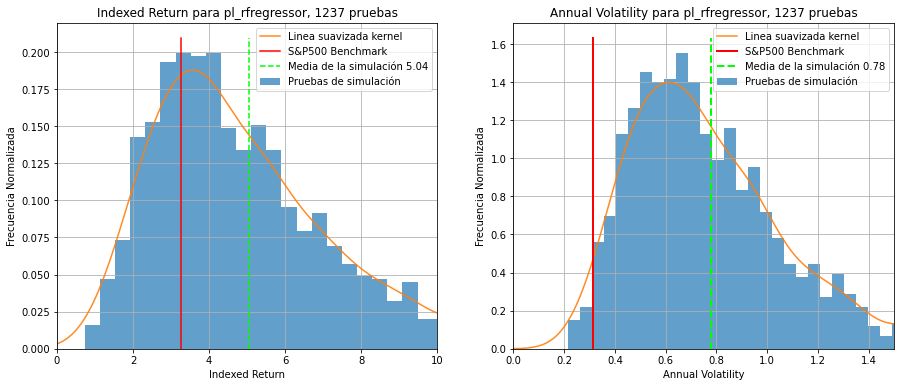

In [41]:
model_file = 'pl_rfregressor'#['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')
plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

In [32]:
results_df.head()

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_linear,6.747275,0.920806
1,1,pl_linear,2.510768,0.316026
2,2,pl_linear,4.925349,0.696925
3,3,pl_linear,6.911006,1.351381
4,4,pl_linear,6.553709,0.902759


In [33]:
results_df

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_linear,6.747275,0.920806
1,1,pl_linear,2.510768,0.316026
2,2,pl_linear,4.925349,0.696925
3,3,pl_linear,6.911006,1.351381
4,4,pl_linear,6.553709,0.902759
...,...,...,...,...
115,115,pl_rfregressor,4.871796,0.670882
116,116,pl_rfregressor,3.635638,0.709240
117,117,pl_rfregressor,3.454092,0.455527
118,118,pl_rfregressor,7.082217,0.942816


In [3]:
results_df = pd.read_csv('Backtest_statistics_Big.csv', index_col=0)

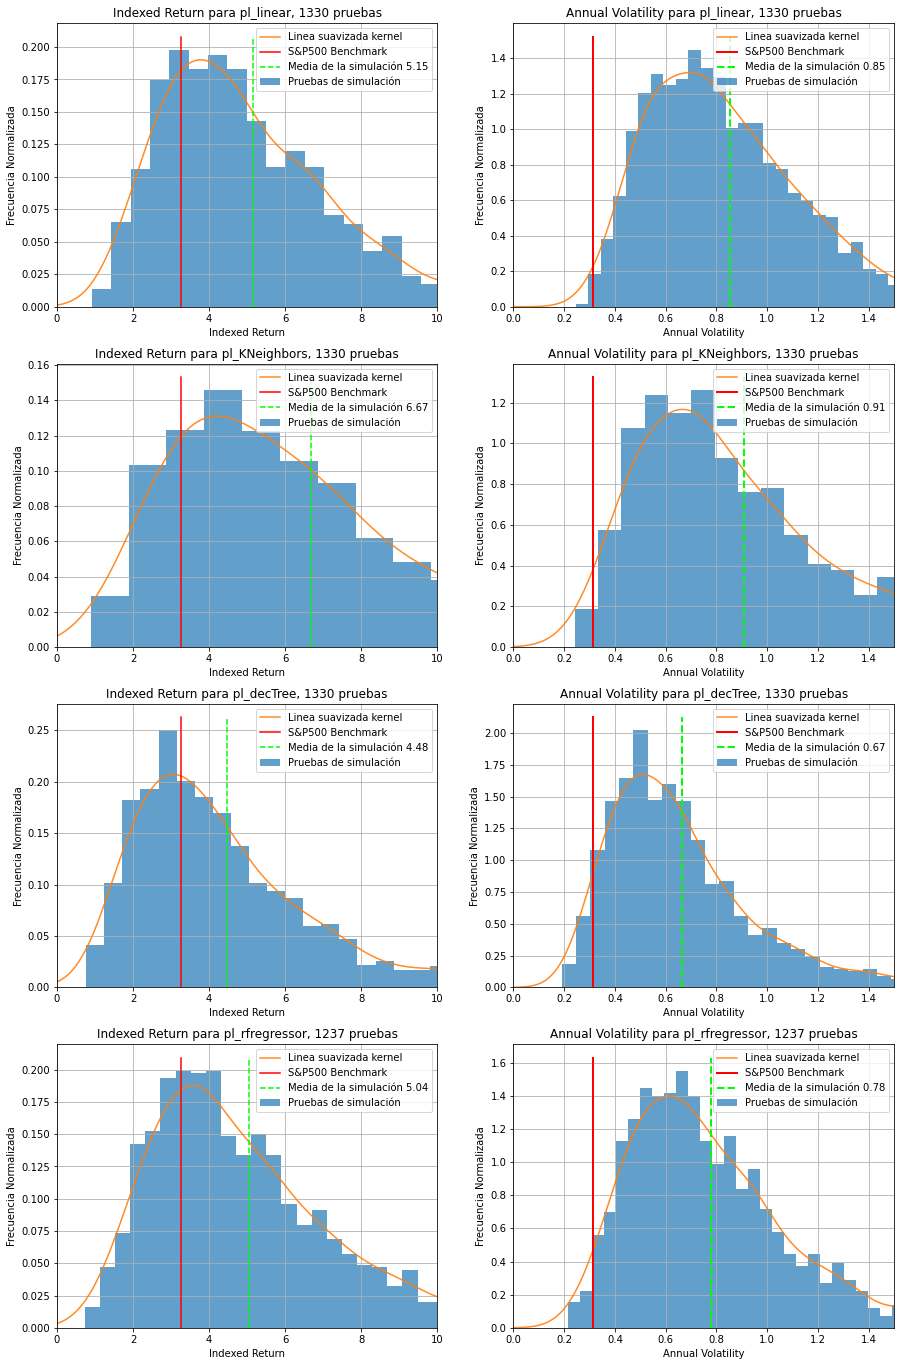

In [42]:
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm']
model_file = ['pl_linear', 'pl_KNeighbors', 'pl_decTree', 'pl_rfregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Decision KNN y RF

Text(0.5, 1.0, 'Retorno K-Vecinos Cercanos vs. Volatilidad')

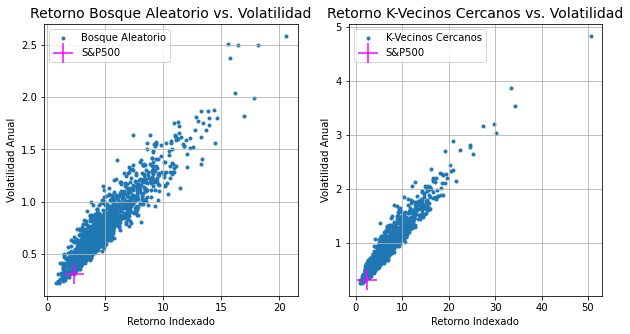

In [44]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_rfregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_rfregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(2.340448, 0.309318, marker='+', color='fuchsia', s=400)
plt.xlabel('Retorno Indexado')
plt.ylabel('Volatilidad Anual')
plt.grid()
plt.legend(['Bosque Aleatorio', 'S&P500'])
plt.title('Retorno Bosque Aleatorio vs. Volatilidad', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(2.340448, 0.309318, marker='+', color='fuchsia', s=400)
plt.xlabel('Retorno Indexado')
plt.ylabel('Volatilidad Anual')
plt.grid()
plt.legend(['K-Vecinos Cercanos', 'S&P500'])
plt.title('Retorno K-Vecinos Cercanos vs. Volatilidad', fontsize=14)

Text(0.5, 0, 'Volatilidad Anual')

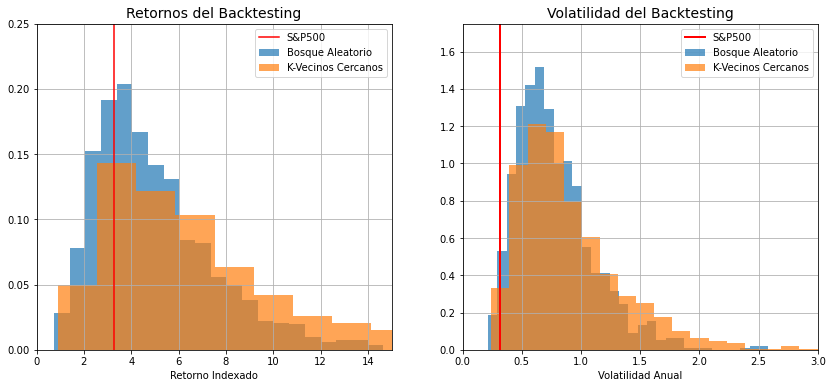

In [48]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_rfregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.xlim(0, 15)
plt.ylim(0, 0.25)
plt.plot([3.251014, 3.251014], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Bosque Aleatorio', 'K-Vecinos Cercanos'])
plt.title('Retornos del Backtesting', fontsize=14)
plt.xlabel('Retorno Indexado')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_rfregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.xlim(0, 3)
plt.ylim(0, 1.75)
plt.plot([0.3131362579812779, 0.3131362579812779], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Bosque Aleatorio', 'K-Vecinos Cercanos'])
plt.title('Volatilidad del Backtesting', fontsize=14)
plt.xlabel('Volatilidad Anual')